В текущем ноутбуке я поряботаю с визуализацией обработанных данных. Это поможет:
- интуитивно понимать паттерны данных лучше
- определить, какие визуализации возможны при построении дашбородов в Power BI и Superset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import wordcloud as wc

In [3]:
df = pd.read_excel('/content/hr_analytics/data/processed/processed.xlsx')
df.head()

,id,name,group,city,salary_from,salary_to,mid_salary,employer,work_format,experience,key_skills,grade
0,126298182,Системный/бизнес аналитик,Системный аналитик,Казань,23200,23200,23200.0,icl services,удалённо,нет опыта,"['Аналитическое мышление', 'Системный анализ',...",стажёр/junior
1,126267340,Разработчик,"Программист, разработчик",Казань,175500,175500,175500.0,таттелеком,в офисе,от 1 года до 3 лет,"['Git', 'PostgreSQL', 'JavaScript', 'SQL', 'Li...",junior+/middle
2,126319001,QA-инженер,Тестировщик,Казань,150000,170000,160000.0,innostage,удалённо,от 3 до 6 лет,"['REST', 'SOAP', 'SQL', 'Git', 'Ручное тестиро...",middle+/senior
3,126271542,Дизайнер интерфейсов,"Дизайнер, художник",Казань,140000,150000,145000.0,кинофлекс,удалённо,от 1 года до 3 лет,"['Figma', 'UI', 'UX']",junior+/middle
4,126243205,Backend Engineer AI,"Программист, разработчик",Казань,60000,80000,70000.0,первый бит,не указано,от 1 года до 3 лет,"['Python', 'Docker', 'SQL', 'FastAPI']",junior+/middle


# Основные графики

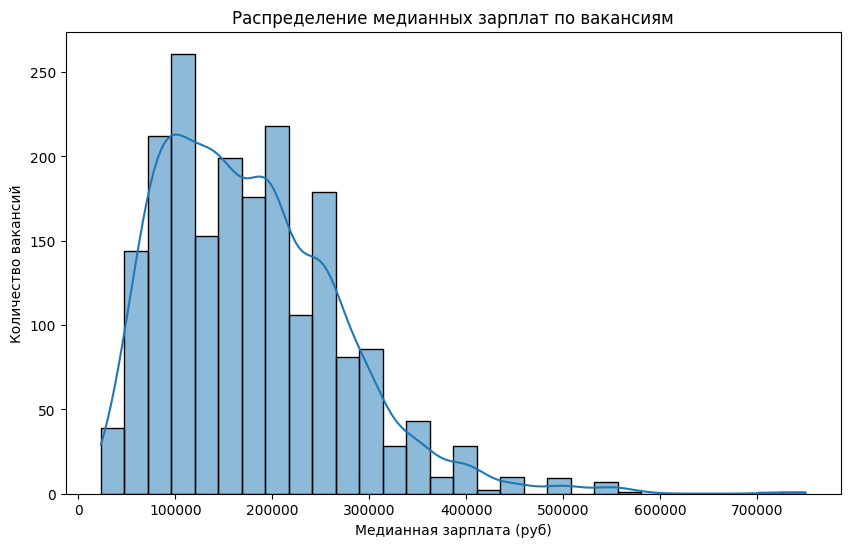

In [11]:
# Отобразим распределение медианных зарплат с плотностью
plt.figure(figsize=(10, 6))
sns.histplot(df['mid_salary'], bins=30, kde=True)
plt.title('Распределение медианных зарплат по вакансиям')
plt.xlabel('Медианная зарплата (руб)')
plt.ylabel('Количество вакансий')
plt.savefig('/content/hr_analytics/images/mid_salary_distribution.jpg')
plt.show()

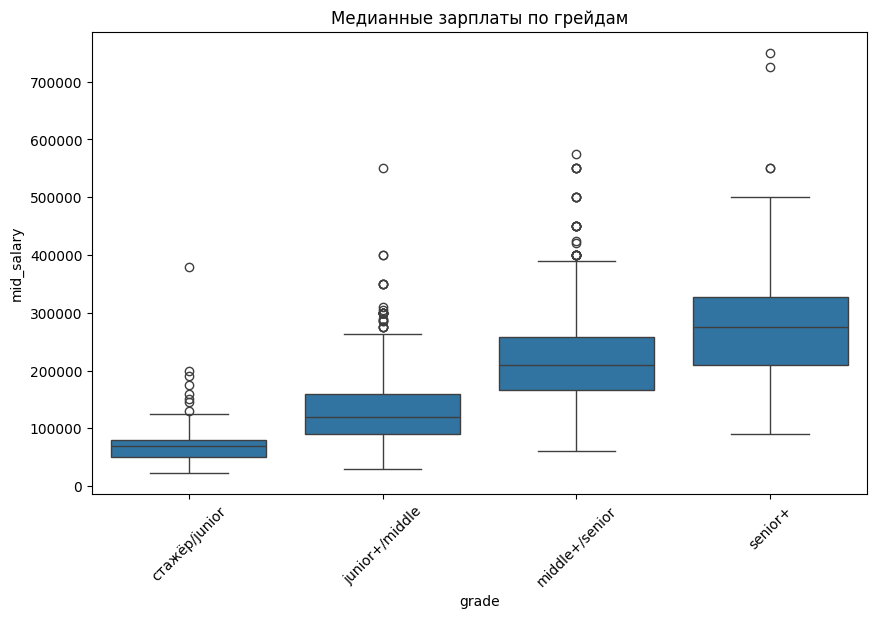

In [12]:
# Быстрое распределение: boxplot, по грейдам и зарплате
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='mid_salary', data=df)
plt.title('Медианные зарплаты по грейдам')
plt.xticks(rotation=45)
plt.savefig('/content/hr_analytics/images/mid_salary_by_grades.jpg')
plt.show()

Наименьший разброс показывают позиции на стажёров и junior-специалистов, что вероятнее всего, связано с отсутствием опыта или его недостатком, в связи с чем оплата держится на фиксированном уровне, по медиане ~70k, в то время как у middle-специалистов ближке к 100, а у senior ближе к 200

In [9]:
jun_grade = df[df['grade'] == 'стажёр/junior']
jun_grade['mid_salary'].median()

70000.0

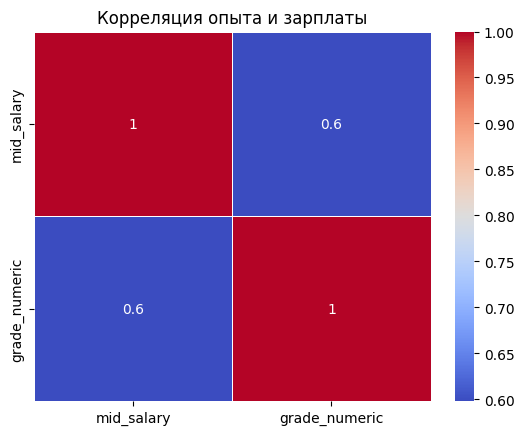

In [13]:
# Дополнительно можно построить scatter plot и heatmap на основе корреляционной матрицы
# Это дополнительно покажет линейную связь опыта и зарплаты
# Привести grade к числовым значениям можно разными способами. Воспользуемся маппером
grade_num = {
    'стажёр/junior': 1,
    'junior+/middle': 2,
    'middle+/senior': 3,
}
df['grade_numeric'] = df['grade'].map(grade_num)
matrix = df[['mid_salary', 'grade_numeric']].corr()

sns.heatmap(matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Корреляция опыта и зарплаты')
plt.savefig('/content/hr_analytics/images/exp_salary_correlation.jpg')
plt.show()

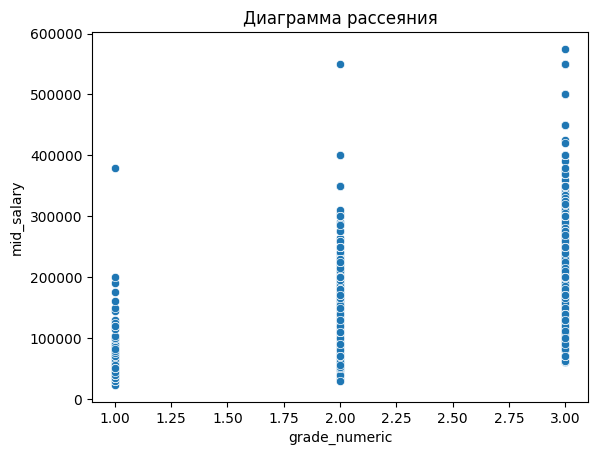

In [14]:
sns.scatterplot(data=df, x='grade_numeric', y='mid_salary')
plt.title('Диаграмма рассеяния')
plt.savefig('/content/hr_analytics/images/grade_salary_scatter.jpg')
plt.show()

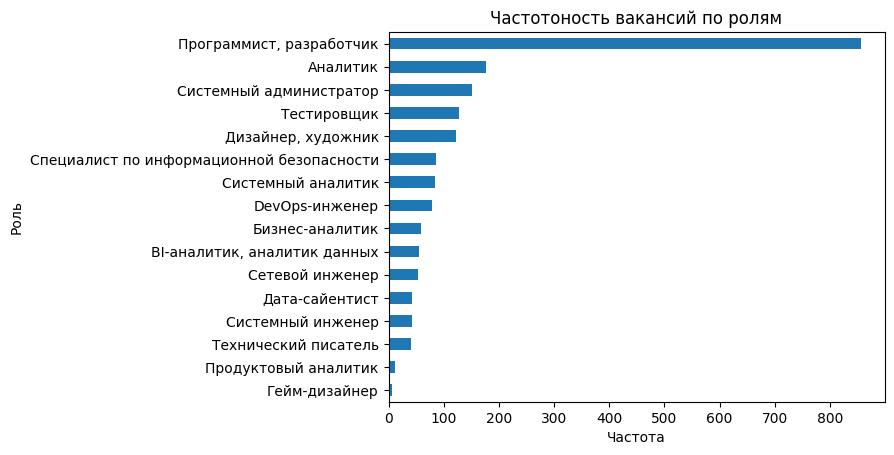

In [15]:
# Простые barplot по категориальным переменным
df['group'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Частотоность вакансий по ролям')
plt.ylabel('Роль')
plt.xlabel('Частота')
plt.savefig('/content/hr_analytics/images/freq_by_role.jpg')
plt.show()

Топ-3: разработчики, аналитики и системные администраторы

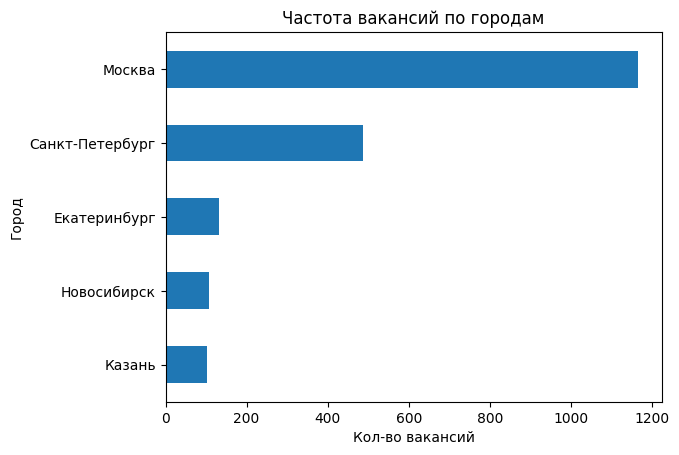

In [16]:
# Частотность по городам - связь прямо пропорциональная населению
df['city'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Частота вакансий по городам')
plt.ylabel('Город')
plt.xlabel('Кол-во вакансий')
plt.savefig('/content/hr_analytics/images/freq_by_cities.jpg')
plt.show()

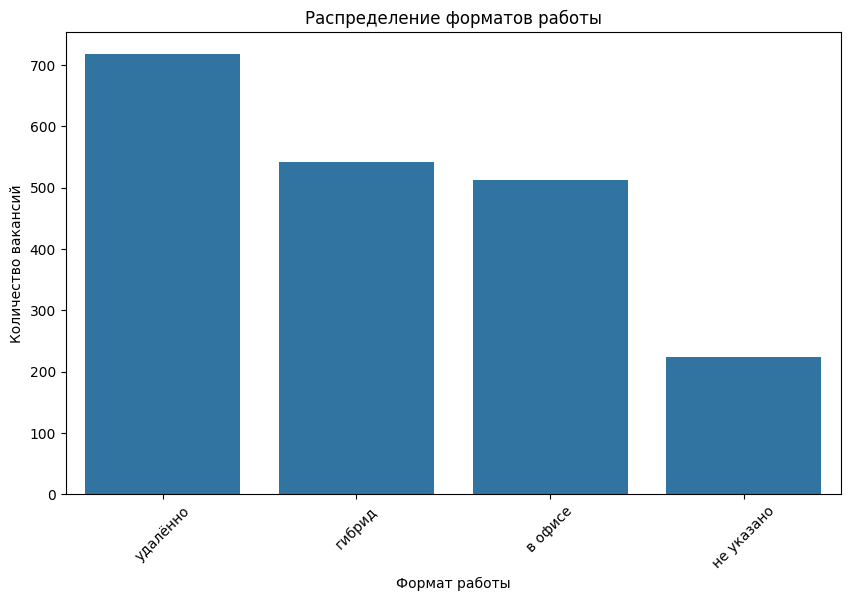

In [17]:
# Формат работы
plt.figure(figsize=(10, 6))
work_counts = df['work_format'].value_counts()
sns.barplot(x=work_counts.index, y=work_counts.values)
plt.title('Распределение форматов работы')
plt.xlabel('Формат работы')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.savefig('/content/hr_analytics/images/work_format_dist.jpg')
plt.show()

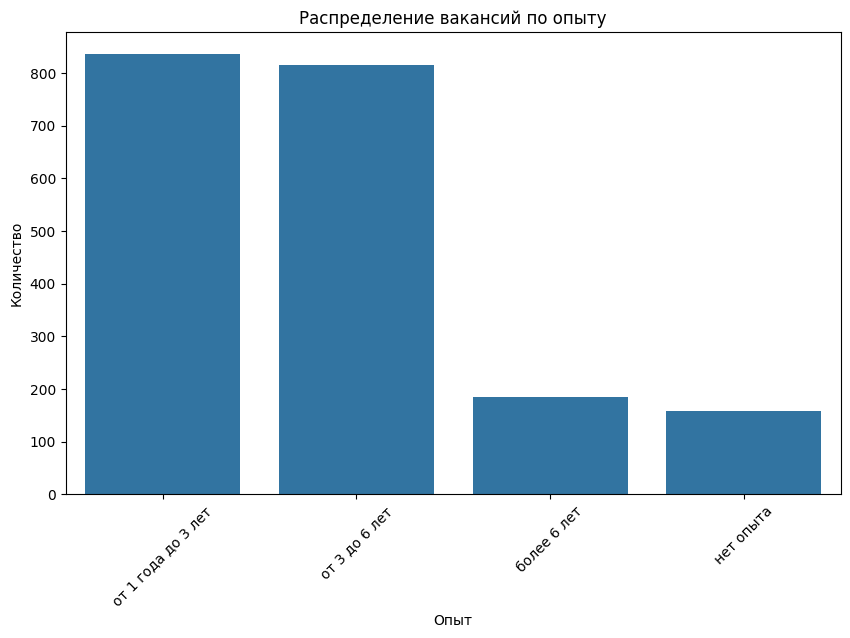

In [18]:
# Распределение опыта
plt.figure(figsize=(10, 6))
exp_counts = df['experience'].value_counts()
sns.barplot(x=exp_counts.index, y=exp_counts.values)
plt.title('Распределение вакансий по опыту')
plt.xlabel('Опыт')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.savefig('/content/hr_analytics/images/exp_dist.jpg')
plt.show()

# Дополнительные графики (сводка, группировка)

<Figure size 1200x800 with 0 Axes>

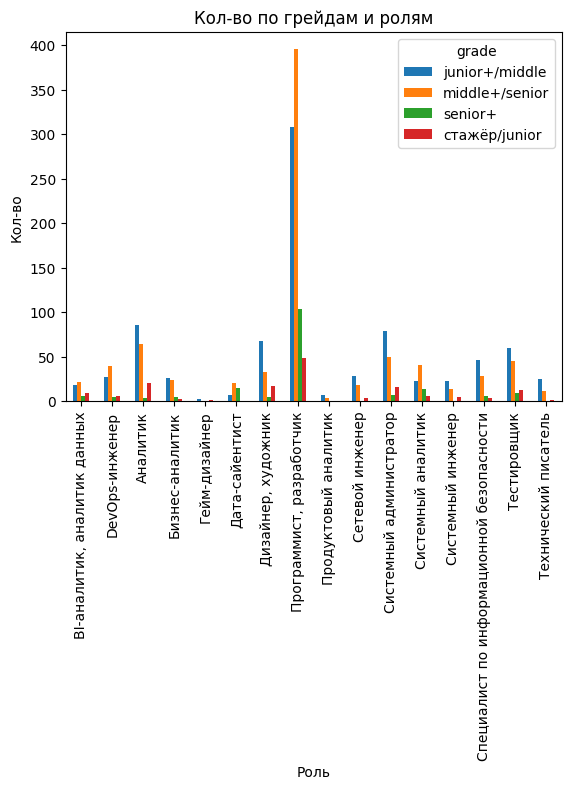

In [19]:
crosstab = pd.crosstab(df['group'], df['grade'])
plt.figure(figsize=(12, 8))
crosstab.plot(kind='bar')
plt.title('Кол-во по грейдам и ролям')
plt.ylabel('Кол-во')
plt.xlabel('Роль')
plt.savefig('/content/hr_analytics/images/group_by_grades_n_roles.jpg')
plt.show()

Видно, что только среди разработчиков и дата-саентистов превалируют мидл-специалисты. Среди остальных ролей больше всего джуниоров

<Figure size 1200x800 with 0 Axes>

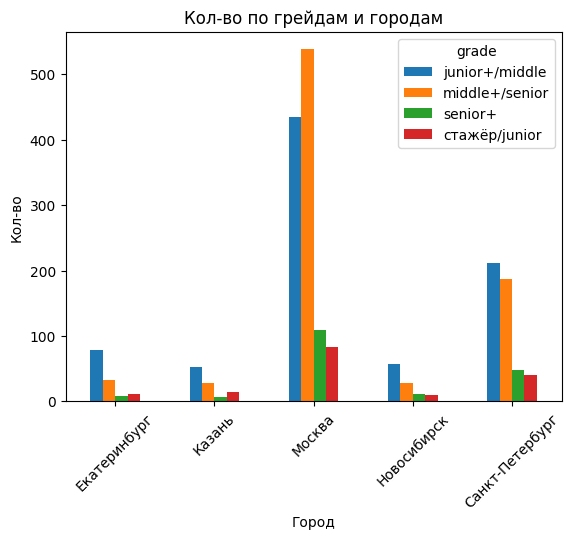

In [20]:
crosstab = pd.crosstab(df['city'], df['grade'])
plt.figure(figsize=(12, 8))
crosstab.plot(kind='bar')
plt.title('Кол-во по грейдам и городам')
plt.ylabel('Кол-во')
plt.xlabel('Город')
plt.xticks(rotation=45)
plt.savefig('/content/hr_analytics/images/group_by_grades_n_cities.jpg')
plt.show()

Здесь же только в Москве и Санкт-Петербурге больше всего мидлов, в отличие от других городов

In [21]:
import ast

def str_to_list(text):
  return ast.literal_eval(text)

df['key_skills'] = df['key_skills'].apply(str_to_list)

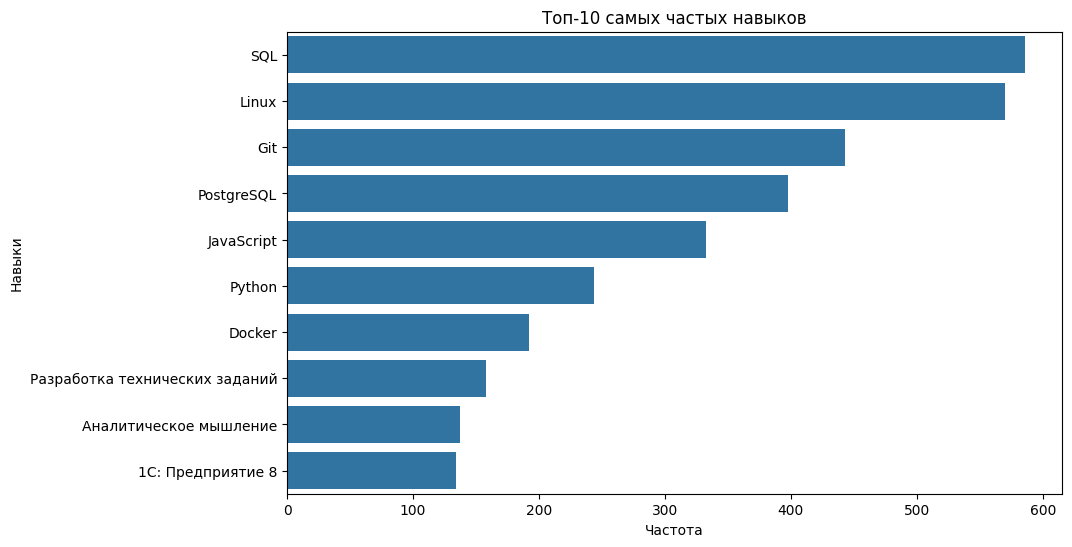

In [22]:
# Топ-10 навыков
all_skills = [skill for skills in df['key_skills'] for skill in skills]
counter = Counter(all_skills).most_common(10)

plt.figure(figsize=(10, 6))
skills, counts = zip(*counter)
sns.barplot(x=list(counts), y=list(skills))
plt.title('Топ-10 самых частых навыков')
plt.xlabel('Частота')
plt.ylabel('Навыки')
plt.savefig('/content/hr_analytics/images/top_ten_skills.jpg')
plt.show()

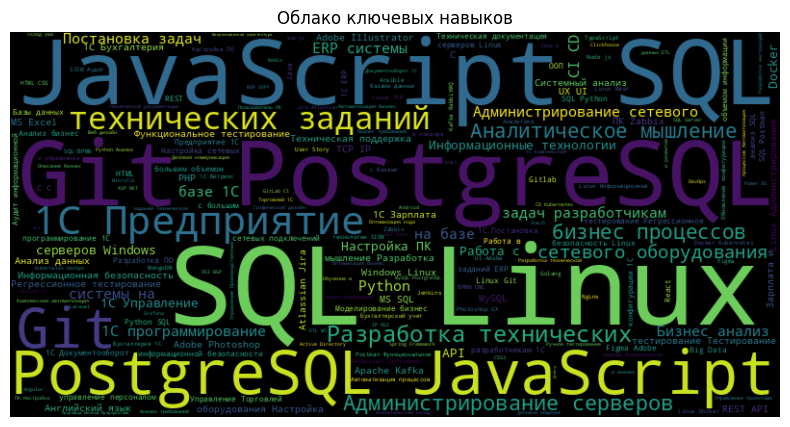

In [23]:
# Облако слов
text = ' '.join(all_skills)
wordcloud = wc.WordCloud(width=800, height=400, background_color='black').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако ключевых навыков')
plt.savefig('/content/hr_analytics/images/key_skills_wordcloud.jpg')
plt.show()

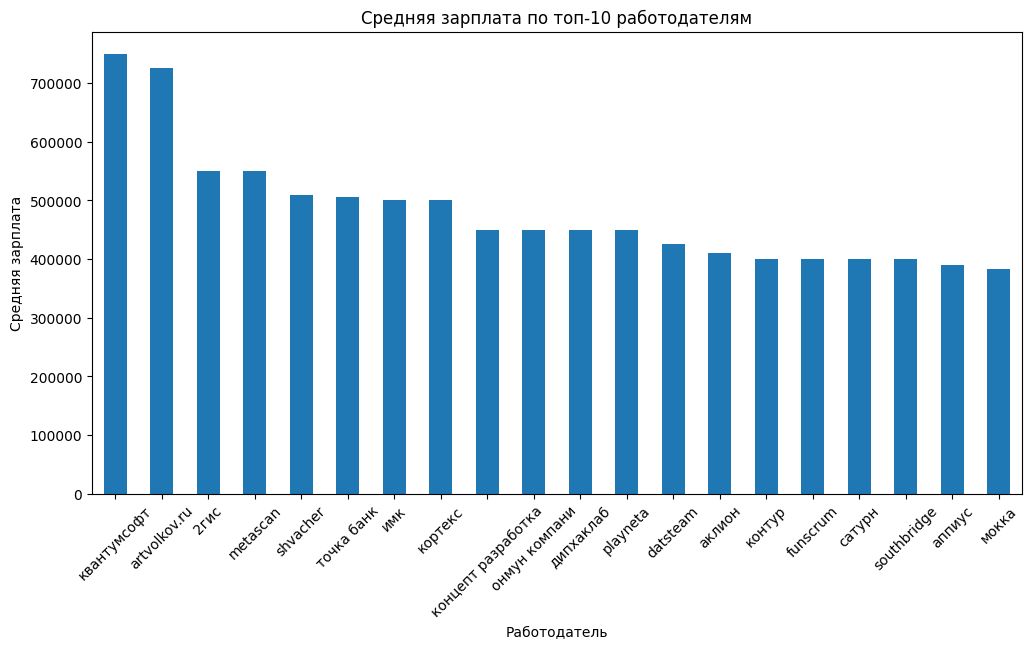

In [24]:
# Сравнение зарплат по работодателям
top_employers = df.groupby('employer')['mid_salary'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
top_employers.plot(kind='bar')
plt.title('Средняя зарплата по топ-10 работодателям')
plt.xlabel('Работодатель')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45)
plt.savefig('/content/hr_analytics/images/mid_salary_by_top_ten_employers.jpg')
plt.show()

Это не самая показательная статистика, т.к. работодатель может опубликовать мало вакансий с высокой зарплатой, что даст ему место в топе